<div align="center">
  <img src="https://raw.githubusercontent.com/flyteorg/static-resources/main/flyte/readme/flyte_and_lf.png" alt="Flyte and LF AI & Data Logo" width="250">
</div>

<h1 align="center">
  Flyte School
</h1>

<h3 align="center">
  Running Notebooks cells, the reproducible way
</h3>

This module guides you on deploying code developed in Notebooks to a Flyte instance for instant reproducibility, versioning, and efficient compute access.

### Learning Objectives

Learn how to:

- Create a connection between your Jupyter Notebook and a Flyte cluster
- Build a container image without writing a Dockerfile
- Run code cells on Flyte and retrieve outputs programatically
- Work with execution outputs to perform EDA and then, train a simple Linear Regression model

### Prepare your Flyte instance

The [sandbox](https://docs.flyte.org/en/latest/deployment/deployment/sandbox.html#flyte-sandbox-as-a-single-docker-container) is a local Flyte instance that runs on your machine and packs all components of a Flyte cluster into a single Docker container.
You can start a Flyte instance using `flytectl demo start`. When you do that, it creates a `config-sandbox.yaml` file on your machine, configured to connect you with the Flyte instance.    

For other deployment options, checkout [the docs](https://docs.flyte.org/en/latest/deployment/deployment/index.html).

In [1]:
import os
from pathlib import Path

os.environ["FLYTECTL_CONFIG"] = str(Path.home() / ".flyte/config-sandbox.yaml") #change to ./flyte/config.yaml if not using Flyte sandbox

#### Install the dependencies in your local environment

In [6]:
!uv pip install -r ./requirements.txt

Using Python 3.12.9 environment at: pyconcol2025
Resolved 109 packages in 3.20s
Prepared 28 packages in 49.69s
Installed 93 packages in 586ms
 + adlfs==2024.12.0
 + aiobotocore==2.23.0
 + aiohappyeyeballs==2.6.1
 + aiohttp==3.12.13
 + aioitertools==0.12.0
 + aiosignal==1.4.0
 + azure-core==1.35.0
 + azure-datalake-store==0.0.53
 + azure-identity==1.23.0
 + azure-storage-blob==12.25.1
 + botocore==1.38.27
 + cachetools==5.5.2
 + click==8.2.1
 + cloudpickle==3.1.1
 + contourpy==1.3.2
 + croniter==6.0.0
 + cryptography==45.0.5
 + cycler==0.12.1
 + dataclasses-json==0.5.9
 + diskcache==5.6.3
 + docker==7.1.0
 + docstring-parser==0.16
 + flyteidl==1.15.3
 + flytekit==1.14.0
 + fonttools==4.58.5
 + frozenlist==1.7.0
 + fsspec==2025.5.1
 + gcsfs==2025.5.1
 + google-api-core==2.25.1
 + google-auth==2.40.3
 + google-auth-oauthlib==1.2.2
 + google-cloud-core==2.4.3
 + google-cloud-storage==3.1.1
 + google-crc32c==1.7.1
 + google-resumable-media==2.7.2
 + googleapis-common-protos==1.70.0
 + grpci

#### Declare the packages your container image should have, and let [ImageSpec](https://docs.flyte.org/en/latest/user_guide/customizing_dependencies/imagespec.html#imagespec) build it

In [7]:
import flytekit as fl
import sys

custom_image = fl.ImageSpec(
    name="notebooks-flyte-intro",
    requirements="./requirements.txt",
    python_version=f"{sys.version_info.major}.{sys.version_info.minor}",
    registry="localhost:30000",#this is the container registry that ships with Flyte sandbox, but you can use any other
    platform="linux/arm64",
 )

task = fl.task(container_image=custom_image)

### Data ingestion

#### Load the data, defining the prediction target and features the model will use

In [8]:
from dataclasses import dataclass, asdict
from typing import Optional, Tuple
import pandas as pd
from palmerpenguins import load_penguins

TARGET = "species"
FEATURES = [
    "bill_length_mm",
    "bill_depth_mm",
    "flipper_length_mm",
    "body_mass_g",
]

@dataclass
class Hyperparameters:
    C: float
    max_iter: Optional[int] = 2500


@task
def get_data() -> pd.DataFrame:
    return load_penguins()[[TARGET] + FEATURES].dropna()


/Users/davidespejo/code/flyte-school/02-notebook-development/pyconcol2025/lib/python3.12/site-packages/palmerpenguins/penguins.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### Configure the remote object and run the task on Flyte

In [9]:
from flytekit.remote import FlyteRemote
from flytekit.configuration import Config

remote = FlyteRemote(
        Config.for_sandbox(),
        default_project="flytesnacks",
        default_domain="development",
        interactive_mode_enabled=True,  # Optional in notebooks - automatically enabled
    )
task_exec = remote.execute(get_data, inputs={}, wait=True)

19:35:42.962078 WARNING  remote.py:286 - Jupyter notebook and interactive task  
                         support is still alpha.

Image localhost:30000/notebooks-flyte-intro:kw_UL7aphCio7WlFVSnlmQ not found. building...
Run command: docker image build --tag localhost:30000/notebooks-flyte-intro:kw_UL7aphCio7WlFVSnlmQ --platform linux/arm64 --push /var/folders/bb/d6y7psts44x19rc2s14v9pv00000gn/T/tmpry691rk8 


#0 building with "desktop-linux" instance using docker driver

#1 [internal] load build definition from Dockerfile
#1 transferring dockerfile: 1.73kB done
#1 DONE 0.0s

#2 resolve image config for docker-image://docker.io/docker/dockerfile:1.5
#2 ...

#3 [auth] docker/dockerfile:pull token for registry-1.docker.io
#3 DONE 0.0s

#2 resolve image config for docker-image://docker.io/docker/dockerfile:1.5
#2 DONE 0.9s

#4 docker-image://docker.io/docker/dockerfile:1.5@sha256:39b85bbfa7536a5feceb7372a0817649ecb2724562a38360f4d6a7782a409b14
#4 CACHED

#5 [internal] load .dockerignore
#5 transferring context: 2B done
#5 DONE 0.0s

#6 [internal] load metadata for docker.io/mambaorg/micromamba:2.0.3-debian12-slim
#6 ...

#7 [auth] library/debian:pull token for registry-1.docker.io
#7 DONE 0.0s

#8 [auth] mambaorg/micromamba:pull token for registry-1.docker.io
#8 DONE 0.0s

#9 [auth] astral-sh/uv:pull token for ghcr.io
#9 DONE 0.0s

#10 [internal] load metadata for ghcr.io/astral-sh/uv:0.5.1
#10

What just happened is that Flyte executed the `get_data` task and we're capturing the result in the `task_exec` variable.      

`wait=True` means the cell will wait until the execution is completed.


#### Inspect the execution

In [10]:
outputs = task_exec.outputs
print(outputs)

{'o0': 's3://my-s3-bucket/data/qj/a8zr8zktn7npwfkqjmvm-getdata-0/68298cb3443a1ba9e92a5e5ac2ea7a14'}


This particular task only returns an output (the dataframe from the `load_penguins()` function).    
By default, Flyte uses a standard naming format for outputs, starting with `o0`
([learn how to customize the output names](https://docs.flyte.org/en/latest/user_guide/basics/named_outputs.html#id1)).

In [11]:
print(task_exec.execution_url)

http://localhost:30080/console/projects/flytesnacks/domains/development/executions/a8zr8zktn7npwfkqjmvm


Follow the link above to go to the Flyte console UI, where you can further explore the execution, its inputs, outputs, logs, and more.

With the execution abstracted as an entity and stored in durable storage, we can start manipulating it freely:

## DETOUR INTO PLAYING WITH VERSIONS ##

In [13]:

print(task_exec.spec)

Flyte Serialized object (ExecutionSpec):
  launch_plan:
    resource_type: 1
    project: flytesnacks
    domain: development
    name: get_data
    version: 4-9y1JbcoFbpwBobEOP6VQ
  metadata:


In [14]:
new_exec = remote.execute(get_data, inputs={}, wait=True, version="4-9y1JbcoFbpwBobEOP6VQ")
print(new_exec.execution_url)

http://localhost:30080/console/projects/flytesnacks/domains/development/executions/ag4jkw99t5mr9ckshlts


### Exploratory Data Analysis (EDA)

In [15]:
dataset = outputs['o0'] #here we retrieve the output from Flyte
print(dataset.head())

  species  bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
0  Adelie            39.1           18.7              181.0       3750.0
1  Adelie            39.5           17.4              186.0       3800.0
2  Adelie            40.3           18.0              195.0       3250.0
4  Adelie            36.7           19.3              193.0       3450.0
5  Adelie            39.3           20.6              190.0       3650.0


This gives us an idea of the features and labels available in this dataset.

#### Number of entries in the data set for each species

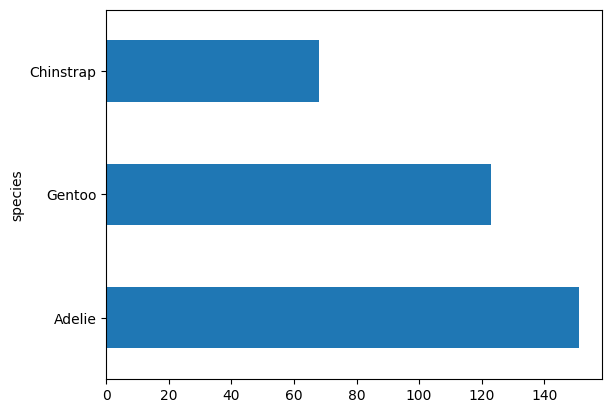

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
dataset['species'].value_counts().plot(kind='barh')
plt.show()

#### Correlation of the variables

Pairplot


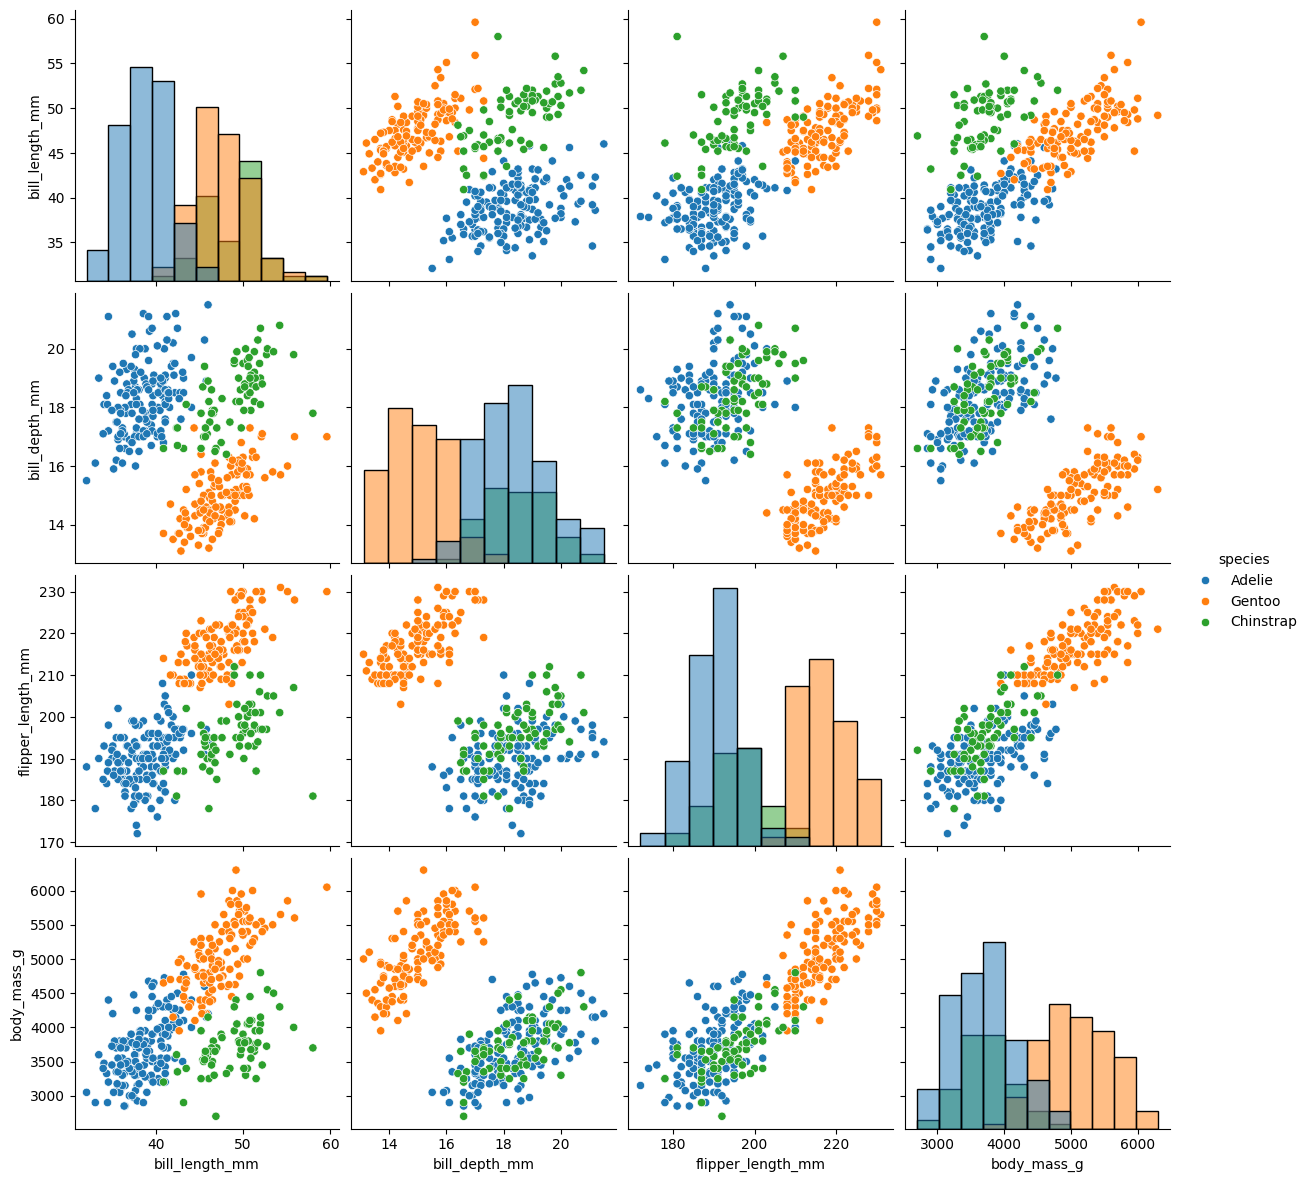

In [17]:
print('Pairplot')
sns.pairplot(data=dataset[['species','bill_length_mm','bill_depth_mm','flipper_length_mm', 'body_mass_g']], hue="species", height=3, diag_kind="hist")
plt.show()

There are additional aspects of the data we could explore, but we have built and understanding of the distribution and potential impact of each feature in the model behavior.

### Split the dataset

In [18]:
from sklearn.model_selection import train_test_split

@task
def split_data(
    data: pd.DataFrame, test_size: float, random_state: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    return train_test_split(
        data,
        test_size=test_size,
        random_state=random_state,
    )

### Model training

#### Train a model using Logistic Regression and calculate the accuracy score

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

@task
def train_model(data: pd.DataFrame, hyperparameters: Hyperparameters) -> LogisticRegression:
    return LogisticRegression(**asdict(hyperparameters)).fit(
        data[FEATURES], data[TARGET]
    )
@task
def evaluate(model: LogisticRegression, data: pd.DataFrame) -> float:
    return float(accuracy_score(data[TARGET], model.predict(data[FEATURES])))


20:12:05.734599 WARNING  type_engine.py:1740 - Unsupported Type <class          
                         'sklearn.linear_model._logistic.LogisticRegression'>   
                         found, Flyte will default to use PickleFile as the     
                         transport. Pickle can only be used to send objects     
                         between the exact same version of Python, and we       
                         strongly recommend to use python type that flyte       
                         support.

### Define a workflow that put all the pieces together

In [20]:
@fl.workflow
def training_workflow(
    hyperparameters: Hyperparameters,
    test_size: float = 0.2,
    random_state: int = 42,
) -> Tuple[LogisticRegression, float, float]: #this is the first output
    # get and split data
    data = get_data()
    train_data, test_data = split_data(
        data=data, test_size=test_size, random_state=random_state
    )
    # train model on the training set
    model = train_model(data=train_data, hyperparameters=hyperparameters)
    # evaluate the model
    train_acc = evaluate(model=model, data=train_data) #second output...
    test_acc = evaluate(model=model, data=test_data)

    # return model with results
    return model, train_acc, test_acc

### Run the workflow

In [21]:
wf_exec = remote.execute(training_workflow, inputs={"hyperparameters": Hyperparameters(C=0.1, max_iter=5000)}, wait = True)
print(wf_exec.execution_url)
print(wf_exec.outputs)

http://localhost:30080/console/projects/flytesnacks/domains/development/executions/arbv84rfxzpt7xtkv8cx
{'o0': 's3://my-s3-bucket/data/b5/arbv84rfxzpt7xtkv8cx-n2-0/3575b9a35781d9146a8a0938baa5fac0/a76a2eac7685361118b8e7a308540b27.joblib', 'o2': 0.9855072463768116, 'o1': 0.9926739926739927}


#### Explore the execution results and versions

In [22]:
print("Training set accuracy: ", wf_exec.outputs['o1'])
print("Validation set accuracy: ", wf_exec.outputs['o2'])

Training set accuracy:  0.9926739926739927
Validation set accuracy:  0.9855072463768116


In [23]:
print(wf_exec.spec)

Flyte Serialized object (ExecutionSpec):
  launch_plan:
    resource_type: 3
    project: flytesnacks
    domain: development
    name: training_workflow
    version: 8-l1TvYR6i6V2_lIlNQLOA
  metadata:
  max_parallelism: 25


## Dealing with changes
If you make a change to the workflow or task code, Flyte will automatically register it as a new task/workflow version so you can have clear tracking and direct reproducibility of your experiment results.   

In the following example, we change some of the parameters:

In [ ]:
@fl.workflow
def training_workflow(
    hyperparameters: Hyperparameters,
    test_size: float = 0.1,
    random_state: int = 5,
) -> Tuple[LogisticRegression, float, float]: #this is the first output
    # get and split data
    data = get_data()
    train_data, test_data = split_data(
        data=data, test_size=test_size, random_state=random_state
    )
    # train model on the training set
    model = train_model(data=train_data, hyperparameters=hyperparameters)
    # evaluate the model
    train_acc = evaluate(model=model, data=train_data) #second output...
    test_acc = evaluate(model=model, data=test_data)

    # return model with results
    return model, train_acc, test_acc

wf_exec = remote.execute(training_workflow, inputs={"hyperparameters": Hyperparameters(C=0.1, max_iter=5000)}, wait = True)
print(wf_exec.execution_url)
print("Training set accuracy: ", wf_exec.outputs['o1'])
print("Validation set accuracy: ", wf_exec.outputs['o2'])


In [30]:
print(wf_exec.spec)

Flyte Serialized object (ExecutionSpec):
  launch_plan:
    resource_type: 3
    project: flytesnacks
    domain: development
    name: training_workflow
    version: 82wEfJVji_pqdXJgp64f4g
  metadata:
  max_parallelism: 25


To launch an execution of a past workflow version, you can do it from the Notebook:

In [28]:
reproducible_exec = remote.execute(training_workflow, inputs={"hyperparameters": Hyperparameters(C=0.1, max_iter=5000)}, version="8-l1TvYR6i6V2_lIlNQLOA", wait = True)

Or from the UI, click on **Launch Workflow** and set the inputs to the same or different values as the original execution:

<image src="https://github.com/unionai-oss/flyte-school/blob/main/02-notebook-development/static/flyte-jupyter-01-GIF.gif?raw=1" width="800px">

## Conclusion

You just learned how Flyte is a robust compute and dataflow engine that can help you speed up experimentation and deliver reproducible models that can be easily shared between teams and inspected by relevant stakeholders.

We've only scratched the surface of what Flyte makes possible for AI engineers.   

To learn more, consider the following resources:


<a href="https://docs.flyte.org/en/latest/">
    <img src="https://img.shields.io/badge/Flyte-Docs-purple?style=for-the-badge" alt="Flyte Docs" />
</a>
<a href="https://slack.flyte.org">
    <img src="https://img.shields.io/badge/Slack-Chat-pink?style=for-the-badge&logo=slack" alt="Flyte Slack" />
</a>
<a href="https://github.com/flyteorg/flyte">
    <img src="https://img.shields.io/badge/Flyte-Github%20Repo-black?style=for-the-badge&logo=github" alt="Flyte Repo" />
</a>
